In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

try:
    from imblearn.over_sampling import SMOTE
except ImportError:
    print("SMOTE library not found. Run: !pip install imblearn")

print("All libraries imported successfully.")

All libraries imported successfully.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing the data
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/project/student_depression_dataset.csv')
df

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


In [5]:
print(f"\nOriginal Dataset Shape: {df.shape}")


Original Dataset Shape: (27901, 18)


In [6]:
#Data Structure Check (Troubleshooting)

print(f"Current number of columns: {len(df.columns)}")
print("Current column names:")
print(df.columns.tolist())


Current number of columns: 18
Current column names:
['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Depression']


In [8]:

expected_column_names = [
    'id', 'Gender', 'Age', 'City', 'Profession', 'Academic_Pressure',
    'Work_Pressure', 'CGPA', 'Study_Satisfaction', 'Job_Satisfaction',
    'Sleep_Duration', 'Dietary_Habits', 'Degree', 'Suicidal_Ideation',
    'Work_Study_Hours', 'Financial_Stress', 'Family_History', 'Depression'
]

# Check if the number of columns matches the expected number
if len(df.columns) == len(expected_column_names):
    df.columns = expected_column_names
    print("Columns renamed successfully based on expected count.")
else:
    print(f"WARNING: Column count mismatch! Expected {len(expected_column_names)} but found {len(df.columns)}.")
    print("Proceeding without full rename, relying on features being present.")

# Drop the 'id' column
if 'id' in df.columns:
    df = df.drop('id', axis=1)
    print("'id' column dropped.")
elif df.columns[0] == 'Unnamed: 0':
    # Handle common case
    df = df.drop(df.columns[0], axis=1)
    print("Unnamed index column dropped.")

# Handle string representations of 'Yes/No'
binary_map = {'Yes': 1, 'No': 0, 'true': 1, 'false': 0}
binary_cols_to_map = ['Suicidal_Ideation', 'Family_History']

for col in binary_cols_to_map:
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].replace(binary_map)
        print(f"Binary feature '{col}' encoded.")

print(f"Final Data shape after cleaning: {df.shape}")

Proceeding without full rename, relying on features being present.
Final Data shape after cleaning: (27901, 17)


Target Variable Distribution
Depression
1    58.549873
0    41.450127
Name: proportion, dtype: float64


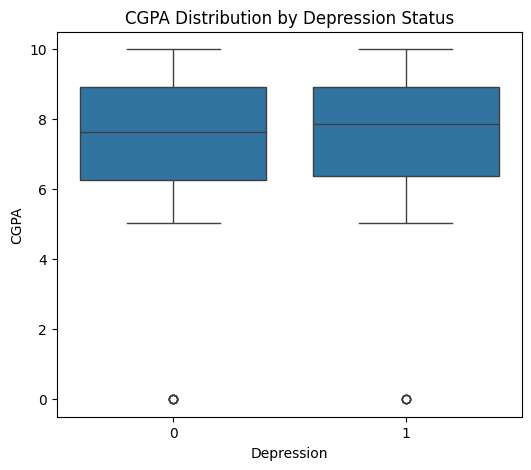

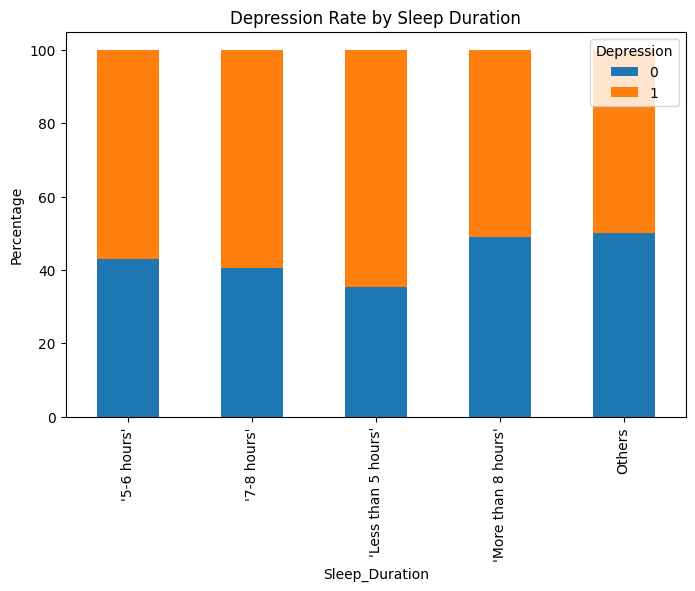

EDA visualizations displayed.


In [9]:
#Exploratory Data Analysis (EDA) and Visualization

print("Target Variable Distribution")
print(df['Depression'].value_counts(normalize=True) * 100)

# Bivariate Analysis: CGPA vs. Depression (Numerical vs. Target)
plt.figure(figsize=(6, 5))
sns.boxplot(x='Depression', y='CGPA', data=df)
plt.title('CGPA Distribution by Depression Status')
plt.show()

# Bivariate Analysis: Sleep Duration vs. Depression (Categorical vs. Target)
plt.figure(figsize=(8, 5))
ct = pd.crosstab(df['Sleep_Duration'], df['Depression'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Depression Rate by Sleep Duration')
plt.ylabel('Percentage')
plt.show()

print("EDA visualizations displayed.")

In [11]:
#Advanced Feature Engineering

numerical_cols_to_check = [
    'Academic_Pressure', 'Work_Pressure', 'Financial_Stress',
    'CGPA', 'Work_Study_Hours', 'Age', 'Study_Satisfaction', 'Job_Satisfaction'
]

for col in numerical_cols_to_check:
    if col in df.columns:
        # Convert to numeric, setting any unconvertible string/text to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Fill NaN values with the median
        df[col] = df[col].fillna(df[col].median())
        print(f"Coerced '{col}' to numeric and imputed NaNs with median.")


#1. Stress Index Feature
stress_cols = ['Academic_Pressure', 'Work_Pressure', 'Financial_Stress']
if all(col in df.columns for col in stress_cols):
    df['Total_Stress'] = df['Academic_Pressure'] + df['Work_Pressure'] + df['Financial_Stress']
    print("Created 'Total_Stress' feature.")
else:
    print(f"WARNING: Skipping 'Total_Stress'. Missing columns: {[col for col in stress_cols if col not in df.columns]}")


#2. Study Efficiency Feature (CGPA / Work/Study Hours)
efficiency_cols = ['CGPA', 'Work_Study_Hours']
if all(col in df.columns for col in efficiency_cols):
    epsilon = 1e-6
    df['Study_Efficiency'] = df['CGPA'] / (df['Work_Study_Hours'] + epsilon)

    # Cap extreme outliers (e.g., very high CGPA with near-zero study hours)
    q_99 = df['Study_Efficiency'].quantile(0.99)
    df['Study_Efficiency'] = df['Study_Efficiency'].clip(upper=q_99)
    print("Created 'Study_Efficiency' (CGPA/Hours) feature.")
else:
    print(f"WARNING: Skipping 'Study_Efficiency'. Missing columns: {[col for col in efficiency_cols if col not in df.columns]}")


#3. Categorical Simplification
if 'Profession' in df.columns:
    # Simplify 'Profession' to binary (Student vs. Non-Student/Other)
    df['Profession'] = df['Profession'].apply(lambda x: 'Student' if 'Student' in str(x) else 'Non-Student/Other')
    print("Simplified 'Profession' feature.")

if 'City' in df.columns:
    # Simplify 'City' to a binary feature
    major_cities = ['Kalyan', 'Srinagar', 'Bangalore', 'Visakhapatnam', 'Pune', 'Thane', 'Chennai', 'Nagpur']
    df['Is_Major_City'] = df['City'].apply(lambda x: 1 if str(x) in major_cities else 0)
    df = df.drop('City', axis=1) # Drop the original City column
    print("Simplified 'City' to 'Is_Major_City'.")
else:
    # Create the feature with default 0 if City column is missing
    df['Is_Major_City'] = 0
    print("WARNING: 'City' column not found. Created 'Is_Major_City' with default 0.")


#4. Ordinal Feature Mapping
ordinal_sleep_map = {'Less than 5 hours': 1, '5-6 hours': 2, '7-8 hours': 3, 'Other (12245)': 0}
ordinal_diet_map = {'Unhealthy': 1, 'Moderate': 2, 'Healthy': 3, 'Other (7663)': 0}

if 'Sleep_Duration' in df.columns:
    df['Sleep_Duration_Encoded'] = df['Sleep_Duration'].map(ordinal_sleep_map).fillna(0)
    df = df.drop('Sleep_Duration', axis=1)
    print("Encoded 'Sleep_Duration'.")
else:
    df['Sleep_Duration_Encoded'] = 0
    print("WARNING: 'Sleep_Duration' column not found. Created 'Sleep_Duration_Encoded' with default 0.")


if 'Dietary_Habits' in df.columns:
    df['Dietary_Habits_Encoded'] = df['Dietary_Habits'].map(ordinal_diet_map).fillna(0)
    df = df.drop('Dietary_Habits', axis=1)
    print("Encoded 'Dietary_Habits'.")
else:
    df['Dietary_Habits_Encoded'] = 0
    print("WARNING: 'Dietary_Habits' column not found. Created 'Dietary_Habits_Encoded' with default 0.")


print("\nFeature Engineering complete.")
print(f"Final features: {df.columns.tolist()}")

Coerced 'Academic_Pressure' to numeric and imputed NaNs with median.
Coerced 'Work_Pressure' to numeric and imputed NaNs with median.
Coerced 'Financial_Stress' to numeric and imputed NaNs with median.
Coerced 'CGPA' to numeric and imputed NaNs with median.
Coerced 'Work_Study_Hours' to numeric and imputed NaNs with median.
Coerced 'Age' to numeric and imputed NaNs with median.
Coerced 'Study_Satisfaction' to numeric and imputed NaNs with median.
Coerced 'Job_Satisfaction' to numeric and imputed NaNs with median.
Created 'Total_Stress' feature.
Created 'Study_Efficiency' (CGPA/Hours) feature.
Simplified 'Profession' feature.

Feature Engineering complete.
Final features: ['Gender', 'Age', 'Profession', 'Academic_Pressure', 'Work_Pressure', 'CGPA', 'Study_Satisfaction', 'Job_Satisfaction', 'Degree', 'Suicidal_Ideation', 'Work_Study_Hours', 'Financial_Stress', 'Family_History', 'Depression', 'Total_Stress', 'Study_Efficiency', 'Is_Major_City', 'Sleep_Duration_Encoded', 'Dietary_Habits_En

In [12]:
#Data Split and Preprocessing Pipeline Setup

X = df.drop('Depression', axis=1)
y = df['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(f"Train/Test split: {X_train.shape[0]} / {X_test.shape[0]}")

#Define Feature Groups
numerical_features = ['Age', 'Academic_Pressure', 'Work_Pressure', 'CGPA',
                      'Study_Satisfaction', 'Job_Satisfaction', 'Work_Study_Hours',
                      'Financial_Stress', 'Total_Stress', 'Study_Efficiency',
                      'Sleep_Duration_Encoded', 'Dietary_Habits_Encoded']

categorical_features = ['Gender', 'Profession', 'Degree']

#ColumnTransformer Setup
preprocessor = ColumnTransformer(
    transformers=[
        # Numerical Pipeline: Standard Scale
        ('num', StandardScaler(), numerical_features),

        # Categorical Pipeline: One-Hot Encode (Drop first to prevent multicollinearity)
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features),

        ('bin', 'passthrough', ['Suicidal_Ideation', 'Family_History', 'Is_Major_City'])
    ],
    remainder='drop'
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

feature_names = (
    numerical_features +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)) +
    ['Suicidal_Ideation', 'Family_History', 'Is_Major_City']
)
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print("Preprocessing Pipeline (ColumnTransformer) applied successfully.")

Train/Test split: 20925 / 6976
Preprocessing Pipeline (ColumnTransformer) applied successfully.


In [13]:
#Handling Class Imbalance (SMOTE)

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE only on the training data
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

print(f"Original Training Target Distribution:\n{y_train.value_counts()}")
print("-" * 40)
print(f"Resampled Training Target Distribution (Balanced):\n{y_train_res.value_counts()}")
print("SMOTE applied to balance the classes.")

Original Training Target Distribution:
Depression
1    12252
0     8673
Name: count, dtype: int64
----------------------------------------
Resampled Training Target Distribution (Balanced):
Depression
0    12252
1    12252
Name: count, dtype: int64
SMOTE applied to balance the classes.


In [14]:
#Baseline Model Training and Initial Comparison

print("Initial Baseline Model Training")

#All models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=10),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=5),
    'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=5)
}

baseline_results = {}
X_train_data = X_train_res.copy()
y_train_data = y_train_res.copy()

for name, model in models.items():
    print(f"Training Baseline: {name}...")

    temp_pipeline = Pipeline(steps=[
        ('selector', SelectKBest(score_func=f_classif, k='all')),
        ('classifier', model)
    ])

    temp_pipeline.fit(X_train_data, y_train_data)
    y_pred = temp_pipeline.predict(X_test_processed)
    y_prob = temp_pipeline.predict_proba(X_test_processed)[:, 1]

    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_prob)

    baseline_results[name] = {
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }

# Display Results Table
baseline_df = pd.DataFrame(baseline_results).T.sort_values(by='Recall', ascending=False)
print("\nBaseline Model Performance Comparison (Test Set)")
print(baseline_df.to_markdown(floatfmt=".4f"))

# Determine top 2 models for advanced tuning
top_models_for_tuning = baseline_df.head(2).index.tolist()
print(f"\nTop 2 models selected for Advanced Hyperparameter Optimization: {top_models_for_tuning}")

Initial Baseline Model Training
Training Baseline: Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training Baseline: Decision Tree...
Training Baseline: Random Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Training Baseline: XGBoost...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:26:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Baseline: LightGBM...
[LightGBM] [Info] Number of positive: 12252, number of negative: 12252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3703
[LightGBM] [Info] Number of data points in the train set: 24504, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
#Advanced Hyperparameter Optimization using RandomizedSearchCV

print("\nPhase: Advanced Hyperparameter Optimization (Tuning Best Models)")

# Base pipeline with Feature Selection for tuning
base_tuning_pipeline = Pipeline(steps=[
    ('selector', SelectKBest(score_func=f_classif, k=25)),
    ('classifier', RandomForestClassifier(random_state=42))
])

search_grids = []

# Parameter Grid for XGBoost (if selected)
if 'XGBoost' in top_models_for_tuning:
    param_grid_xgb = {
        'classifier': [XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')],
        'classifier__n_estimators': [100, 250, 400],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.05, 0.1, 0.2],
        'selector__k': [20, 30, 'all']
    }
    search_grids.append(param_grid_xgb)

#Parameter Grid for LightGBM (The second best model)
if 'LightGBM' in top_models_for_tuning:
    param_grid_lgbm = {
        'classifier': [LGBMClassifier(random_state=42, class_weight='balanced', verbosity=-1)], # verbosity=-1 hides LightGBM's verbose output
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [5, 10, 15],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [15, 31, 60],
        'selector__k': [20, 30, 'all']
    }
    search_grids.append(param_grid_lgbm)

best_models = {}

print(f"Starting Hyperparameter Tuning for {len(search_grids)} models...")

for grid in search_grids:
    model_name = grid['classifier'][0].__class__.__name__

    random_search = RandomizedSearchCV(
        estimator=base_tuning_pipeline,
        param_distributions=grid,
        n_iter=15,
        scoring='recall',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # Fit on the balanced training data
    random_search.fit(X_train_res, y_train_res)
    best_models[model_name] = random_search.best_estimator_

    print(f"\nBest parameters for {model_name}")
    print(random_search.best_params_)

print("\nOptimization complete.")


--- Phase 2: Advanced Hyperparameter Optimization (Tuning Best Models) ---
Starting Hyperparameter Tuning for 2 models...
Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:39:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Best parameters for XGBClassifier ---
{'selector__k': 'all', 'classifier__n_estimators': 400, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)}
Fitting 3 folds for each of 15 candidates, t

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [10 11 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



--- Best parameters for LGBMClassifier ---
{'selector__k': 30, 'classifier__num_leaves': 31, 'classifier__n_estimators': 300, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier': LGBMClassifier(class_weight='balanced', random_state=42, verbosity=-1)}

Optimization complete. Proceed to Cell 9 for final evaluation.


In [17]:
#Final Evaluation on the Test Set

final_results = {}
best_global_recall = -1
best_final_model = None
best_final_model_name = ""

# Evaluate Optimized Models
for name, model in best_models.items():
    # Use the optimized model (which includes the selector)
    y_pred = model.predict(X_test_processed)
    y_prob = model.predict_proba(X_test_processed)[:, 1]

    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc_roc = roc_auc_score(y_test, y_prob)

    final_results[name] = {
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }

    if recall > best_global_recall:
        best_global_recall = recall
        best_final_model = model
        best_final_model_name = name

results_df = pd.DataFrame(final_results).T.sort_values(by='Recall', ascending=False)

print("\nFinal Optimized Model Performance Comparison (Test Set)")
print(results_df.to_markdown(floatfmt=".4f"))

print(f"\nThe FINAL BEST MODEL is: {best_final_model_name}")


Final Optimized Model Performance Comparison (Test Set)
|               |   Recall |   F1-Score |   AUC-ROC |
|:--------------|---------:|-----------:|----------:|
| XGBClassifier |   0.8776 |     0.8663 |    0.9142 |

The FINAL BEST MODEL is: XGBClassifier


 Classification Report for XGBClassifier 
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      2892
           1       0.86      0.88      0.87      4084

    accuracy                           0.84      6976
   macro avg       0.84      0.83      0.84      6976
weighted avg       0.84      0.84      0.84      6976



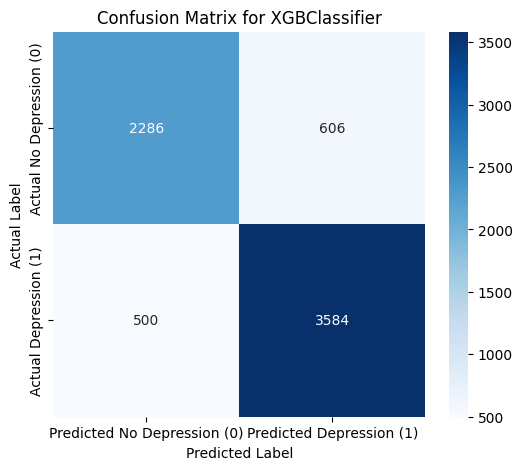

In [19]:
#Report for the Best Model

y_pred_final = best_final_model.predict(X_test_processed)

print(f" Classification Report for {best_final_model_name} ")
print(classification_report(y_test, y_pred_final, zero_division=0))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No Depression (0)', 'Predicted Depression (1)'],
            yticklabels=['Actual No Depression (0)', 'Actual Depression (1)'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix for {best_final_model_name}')
plt.show()


Top 10 Key Risk Factors (Feature Importance)
These factors have the highest predictive power for student depression:
|    | Feature            |   Importance |
|---:|:-------------------|-------------:|
| 40 | Suicidal_Ideation  |       0.4545 |
|  8 | Total_Stress       |       0.1745 |
|  1 | Academic_Pressure  |       0.0663 |
|  6 | Work_Study_Hours   |       0.0352 |
| 41 | Family_History     |       0.0308 |
|  4 | Study_Satisfaction |       0.0300 |
|  0 | Age                |       0.0238 |
| 12 | Gender_Male        |       0.0109 |
|  7 | Financial_Stress   |       0.0107 |
| 14 | Degree_B.Com       |       0.0097 |


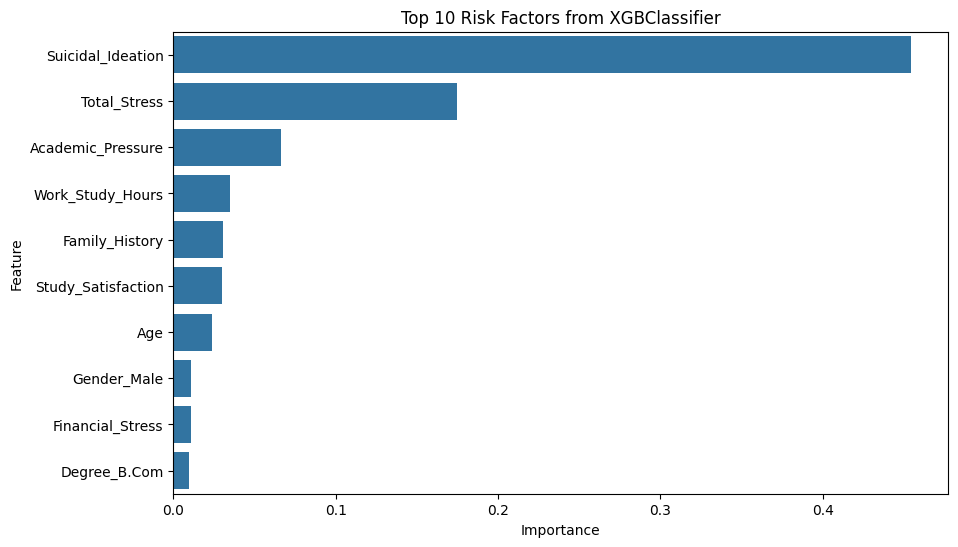

In [20]:
#Feature Importance Analysis (Identifying Key Risk Factors)

classifier = best_final_model.named_steps['classifier']
selector = best_final_model.named_steps['selector']

selected_features_mask = selector.get_support()
selected_features = np.array(feature_names)[selected_features_mask]

if hasattr(classifier, 'feature_importances_'):
    importances = classifier.feature_importances_
    selected_importances = importances[selector.get_support()]

    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': selected_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 10 Key Risk Factors (Feature Importance)")
    print("These factors have the highest predictive power for student depression:")
    print(feature_importance_df.head(10).to_markdown(floatfmt=".4f"))

    # Visualize Feature Importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f'Top 10 Risk Factors from {best_final_model_name}')
    plt.show() #
else:
    print(f"Feature importance method not directly supported by {best_final_model_name} classifier.")
